# Visualize AFOG Attacks on Detrex
This notebook provides code for visualizing attacks on single COCO images for all models implemented with Detrex, including EVA, FocalNet, ConvNeXt, DETA, InternImage, AlignDETR, ViTDet. Please following setup instructions in README.md prior to running this notebook.

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import os
import sys
sys.path.append(os.getcwd()[:os.getcwd().find("demos")])
import time
import torch
from torch.nn.parallel import DataParallel, DistributedDataParallel

from afog.attacks import *
import matplotlib.pyplot as plt
import cv2

from detectron2.config import LazyConfig, instantiate
from detectron2.engine import (
    SimpleTrainer,
    default_argument_parser,
    default_setup,
    hooks,
    launch,
)

import json
from utils.dino_utils.visualizer import COCOVisualizer
from torchvision.datasets import CocoDetection

from detectron2.engine.defaults import create_ddp_model
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.utils import comm
from detectron2.utils.file_io import PathManager
from detectron2.utils.events import (
    CommonMetricPrinter, 
    JSONWriter, 
    TensorboardXWriter
)
from detectron2.checkpoint import DetectionCheckpointer
# from detrex.checkpoint import DetectionCheckpointer

from detrex.utils import WandbWriter
from detrex.modeling import ema

#sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))

from detrex.modeling import ema
from utils.dino_utils import box_ops

import matplotlib.pyplot as plt

/storage/ice1/5/9/zyahn3/TOG_plus/models/detrex/detrex/layers/dcn_v3.py:23: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/storage/ice1/5/9/zyahn3/TOG_plus/models/detrex/detrex/layers/dcn_v3.py:52: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/home/hice1/zyahn3/.conda/envs/AFOG/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Select which model to attack by uncommenting its corresponding model file and config file. Change the name of the model file to reflect its location on your system accordingly.

In [2]:
config_file=None
model_path=None
# --- R50 ---
# config_file="../models/detrex/projects/dino/configs/dino-resnet/dino_r50_4scale_12ep.py"
# model_path="../model_files/dino_r50_4scale.pth"
# --- AlignDETR ---
# config_file="../models/detrex/projects/align_detr/configs/aligndetr_k=2_r50_4scale_24ep.py"
# model_path="../model_files/aligndetr_r50_multi_4scale_24ep.pth"
# --- ViTDet ---
# config_file="../models/detrex/projects/dino/configs/dino-vitdet/dino_vitdet_base_4scale_50ep.py"
# model_path="../model_files/vitdet.pth"
# --- ConvNeXt ---
# config_file="../models/detrex/projects/dino/configs/dino-convnext/dino_convnext_large_384_4scale_12ep.py"
# model_path="../model_files/convnext.pth"
# --- InternImage ---
config_file = "../models/detrex/projects/dino/configs/dino-internimage/dino_internimage_large_4scale_12ep.py"
model_path = '../model_files/internimage.pth'
# --- FocalNet ---
# config_file="../models/detrex/projects/dino/configs/dino-focal/dino_focalnet_large_lrf_384_fl4_5scale_36ep.py"
# model_path="../model_files/focalnet.pth"
# --- EVA ---
# config_file="../models/detrex/projects/dino_eva/configs/dino-eva-01/dino_eva_01_1280_4scale_12ep.py"
# model_path="../model_files/dino_eva_01.pth"
# --- DETA ---
# config_file="../models/detrex/projects/deta/configs/deta_swin_large_finetune_24ep.py"
# model_path="../model_files/deta.pth"

Prepare the config and load in the model.

In [5]:
cfg = None
cfg = LazyConfig.load(config_file)
opts = ["train.init_checkpoint="+model_path]

cfg = LazyConfig.apply_overrides(cfg, opts)
cfg.eval_only = True
default_setup(cfg, cfg)

with open('../utils/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}
print(opts)

with open('../utils/coco_id2name_detectron.json') as f:
    id2name_d = json.load(f)
    id2name_d = {int(k):v for k,v in id2name_d.items()}

model = instantiate(cfg.model)
model.to(cfg.train.device)
model = create_ddp_model(model)
model.training = False
ema.may_build_model_ema(cfg, model)
DetectionCheckpointer(model, **ema.may_get_ema_checkpointer(cfg, model)).load(cfg.train.init_checkpoint)
dataset = CocoDetection("../datasets/coco/val2017","../datasets/coco/annotations/instances_val2017.json")

[11/13 15:26:08 detectron2]: Rank of current process: 0. World size: 1
[11/13 15:26:08 detectron2]: Environment info:
-------------------------------  ------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:12:24) [GCC 11.2.0]
numpy                            1.26.4
detectron2                       0.6 @/storage/ice1/5/9/zyahn3/TOG_plus/models/detrex/detectron2/detectron2
Compiler                         GCC 12.3
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.4.1 @/home/hice1/zyahn3/.conda/envs/AFOG/lib/python3.12/site-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    Yes
GPU 0                            Tesla V100-PCIE-32GB (arch=7.0)
Driver version                   555.42.

WARNING [11/13 15:26:08 d2.config.lazy]: The config contains objects that cannot serialize to a valid yaml. ./output/dino_internimage_large_384_4scale_12ep/config.yaml is human-readable but cannot be loaded.
WARNING [11/13 15:26:08 d2.config.lazy]: Config is saved using cloudpickle at ./output/dino_internimage_large_384_4scale_12ep/config.yaml.pkl.
[11/13 15:26:08 detectron2]: Full config saved to ./output/dino_internimage_large_384_4scale_12ep/config.yaml
[11/13 15:26:08 d2.utils.env]: Using a generated random seed 8598595
['train.init_checkpoint=../model_files/internimage.pth']
[11/13 15:26:08 InternImage]: using core type: DCNv3
[11/13 15:26:08 InternImage]: using activation layer: GELU
[11/13 15:26:08 InternImage]: using main norm layer: LN
[11/13 15:26:08 InternImage]: using dpr: linear, 0.0
[11/13 15:26:08 InternImage]: level2_post_norm: False
[11/13 15:26:08 InternImage]: level2_post_norm_block_ids: None
[11/13 15:26:08 InternImage]: res_post_norm: False
[11/13 15:26:13 d2.check

Helper functions for preparing and visualizing attacks on a single image.

In [11]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).cuda()
    return b

def viz_gt(im_num, caption="Ground Truth"):
    image = torch.tensor(np.array(dataset[im_num][0]), dtype=torch.float32)
    image = (image - image.mean()) / image.std()
    image = image.permute((2, 0, 1))
            
    boxes = torch.tensor([item["bbox"] for item in dataset[im_num][1]])
    labels = torch.tensor([item["category_id"] for item in dataset[im_num][1]])
    print(labels)
    
    box_labels = [id2name[int(label)] for label in labels]
    
    W = image.shape[2]
    H = image.shape[1]
    
    # Resize boxes to [0, 1] and scale xy coordinate to center instead of corner
    boxes[:, 0] += boxes[:, 2] / 2
    boxes[:, 1] += boxes[:, 3] / 2
    boxes[:, :] /= torch.tensor((W, H, W, H))
    

    pred_dict = {
        'boxes': boxes,
        'size': torch.tensor((H, W)),
        'box_label': box_labels
    }
    vslzr = COCOVisualizer()
    vslzr.visualize(image, pred_dict, savedir=None, caption=caption)

from matplotlib.cm import coolwarm
def visualize_attack(im_num, model, attack, attack_mode, n_iter=10):
    image = torch.tensor(np.array(dataset[im_num][0]).transpose((2, 0, 1)), dtype=torch.float32)
    image = image.float()
    meta = dataset[im_num][1][0]
    meta["image"] = image.float().cuda()    
    x_adv, etas, eta_grads, map_grads, maps = attack(model, x_query = image, mode=attack_mode, vis=True, meta=dataset[im_num][1][0])
    
    # normalize grads to make them easier to see
    perts = np.multiply(etas, maps)
    perts_norm = [(grad - np.min(grad)) / (np.max(grad) - np.min(grad)) for grad in perts]
    perts_norm = [np.clip(1 - np.abs(pert - np.median(pert)), 0, 1) for pert in perts_norm]
    
    eta_grads_norm = [(grad - np.min(grad)) / (np.max(grad)-np.min(grad)) for grad in eta_grads]
    eta_grads_norm = [np.clip(1 - 5*np.abs(grad - np.median(grad)), 0, 1) for grad in eta_grads_norm]
    
    map_grads_norm = [(grad - np.min(grad)) / (0.001 + np.max(grad)-np.min(grad)) for grad in map_grads]
    map_grads_norm = [np.clip(1 - 5*np.abs(grad - np.median(grad)), 0, 1) for grad in map_grads_norm]
    
    etas_norm = [(eta - np.min(eta)) / (np.max(eta)-np.min(eta)) for eta in etas]
    etas_norm = [10 * np.clip(1 - np.abs(eta - np.median(eta)), 0, 1) for eta in etas_norm]
    
    maps_norm = [(m - np.min(m)) / (0.001 + np.max(m)-np.min(m)) for m in maps]
    maps_norm = [np.clip(1 - np.abs(m - np.median(m)), 0, 1) for m in maps_norm]
    
    fig, ax = plt.subplots(nrows=n_iter, ncols=5, figsize=(15, n_iter*3+8))

    for i in range(n_iter):
        colormap = "RdYlBu"
        ax[i][0].matshow(perts_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][1].matshow(eta_grads_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][2].matshow(maps_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][3].matshow(map_grads_norm[i].squeeze()[0, :, :], cmap=colormap)
        ax[i][4].matshow(etas_norm[i].squeeze()[0, :, :], cmap=colormap)

        ax[i][0].set_title("After Iter " + str(i+1) + ": A*P")
        ax[i][1].set_title("P Grad")
        ax[i][2].set_title("A Map")
        ax[i][3].set_title("A Grad")
        ax[i][4].set_title("P")

    plt.show()

def viz_pred(im_num, model, caption="", attack=None, attack_mode=None):
    image = torch.tensor(np.array(dataset[im_num][0]).transpose((2, 0, 1)), dtype=torch.float32)
    image = image.float()
    
    meta = dataset[im_num][1][0]
    meta["image"] = image.float().cuda()
    if attack != None:
        image = attack(model, x_query = image, mode=attack_mode, n_iter=10, meta=dataset[im_num][1][0]).float()
    
    the_input = [{
        "file_name":"none", 
        "height":image.shape[1],
        "width":image.shape[2], 
        "image_id":0, 
        "image":image, 
    }]
    outputs = model(the_input)
    image = image.float()
    image = (image - image.min()) / (image.max() - image.min())
    print(image.shape)
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    print(std.shape)
    image[0, :, :] -= mean[0]
    image[1, :, :] -= mean[1]
    image[2, :, :] -= mean[2]
    image[0, :, :] /= std[0]
    image[1, :, :] /= std[1]
    image[2, :, :] /= std[2]
    threshold = 0.3
    scores = outputs[0]["instances"].get("scores")
    select_mask = scores > threshold
    labels = outputs[0]["instances"].get("pred_classes")[select_mask]
    box_labels = [id2name_d[int(label)+1] for label in labels]
    boxes = outputs[0]["instances"].get("pred_boxes").tensor[select_mask]
    H = image.shape[1]
    W = image.shape[2]
    
    boxes[:, 2] = (boxes[:, 2] - boxes[:, 0])
    boxes[:, 3] = (boxes[:, 3] - boxes[:, 1])
    boxes[:, 0] = (boxes[:, 0] + boxes[:, 2] / 2)
    boxes[:, 1] = (boxes[:, 1] + boxes[:, 3] / 2)
    boxes[:, :] /= torch.tensor((W, H, W, H)).cuda()
    


    pred_dict = {
        'boxes': boxes,
        'size': torch.tensor((H, W)),
        'box_label': box_labels
    }
    vslzr = COCOVisualizer()
    vslzr.visualize(image, pred_dict, savedir=None, caption=caption)

Select an image and visualize the benign prediction.

/home/hice1/zyahn3/.conda/envs/AFOG/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789220573/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([3, 640, 480])
torch.Size([3])


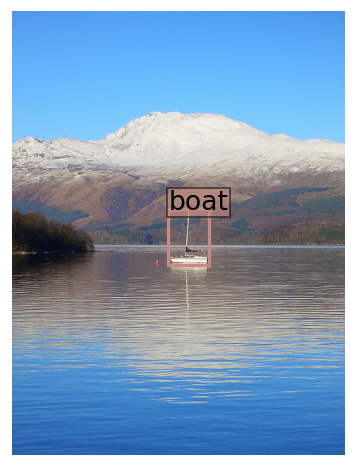

In [7]:
image = 3690
viz_pred(image, model, attack=None, attack_mode="")

Attack the image and visualize the adversarial prediction. Attack mode can be selected by changing attack_mode parameter to either "baseline", "vanishing", or "fabrication."

torch.Size([3, 640, 480])
torch.Size([3])


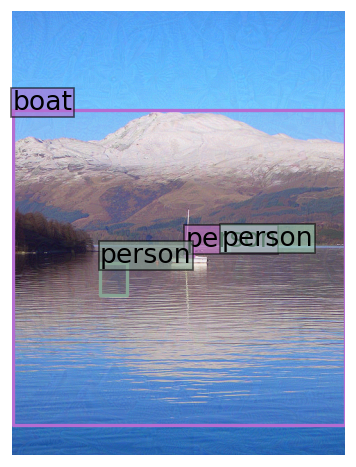

In [15]:
viz_pred(image, model, attack=afog, attack_mode="baseline")

Visualize the internals of AFOG as it iterates, including perturbation map, attention map, and their gradients.

In [ ]:
visualize_attack(image, model, attack=afog, attack_mode="baseline")